#Review and Tip EDA

## Project Step & Environment

In [1]:
!pip install pyspark
!pip install Word2Vec
from IPython.display import clear_output

clear_output()

In [109]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, year, regexp_replace, lower
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import unix_timestamp, year
from pyspark.sql.functions import avg
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
nltk.download('wordnet')
nltk.download('omw-1.4')

clear_output()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
spark = SparkSession.builder.appName("App").master("local[*]").config("spark.driver.memory", "10g").config("spark.executor.memory", "10g").config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12").getOrCreate()

## Data Load and Preview

In [6]:
review = spark.read.parquet("/content/drive/MyDrive/Big_Data_Analytics_Good/review.parquet")
tip = spark.read.parquet("/content/drive/MyDrive/Big_Data_Analytics_Good/tip.parquet")
business = spark.read.parquet("/content/drive/MyDrive/Big_Data_Analytics_Good/business.parquet")

In [12]:
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [11]:
review.show(5, truncate = False)

+----------------------+----+-------------------+-----+----------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------------------+
|business_id           |cool|date               |funny|review_id             |stars|text                                                                                                                                                                                                                        

In [13]:
tip.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [14]:
tip.show(5, truncate = False)

+----------------------+----------------+-------------------+---------------------------------------------------------+----------------------+
|business_id           |compliment_count|date               |text                                                     |user_id               |
+----------------------+----------------+-------------------+---------------------------------------------------------+----------------------+
|3uLgwr0qeCNMjKenHJwPGQ|0               |2012-05-18 02:17:21|Avengers time with the ladies.                           |AGNUgVwnZUey3gcPCJ76iw|
|QoezRbYQncpRqyrLH6Iqjg|0               |2013-02-05 18:35:10|They have lots of good deserts and tasty cuban sandwiches|NBN4MgHP9D3cw--SnauTkA|
|MYoRNLb5chwjQe3c_k37Gg|0               |2013-08-18 00:56:08|It's open even when you think it isn't                   |-copOvldyKh1qr-vzkDEvw|
|hV-bABTK-glh5wj31ps_Jw|0               |2017-06-27 23:05:38|Very decent fried chicken                                |FjMQVZjSqY8syIO-53KFKw|

In [87]:
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [88]:
business.show(5, truncate = False)

+-------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------+-------+----------+------------+------------------------+-----------+------------+-----+-----+
|address                        |attributes                                                                                                                                                                                                                                                                                                    

In [23]:
review.select("stars", "useful", "funny", "cool").describe().show()

+-------+------------------+------------------+-------------------+------------------+
|summary|             stars|            useful|              funny|              cool|
+-------+------------------+------------------+-------------------+------------------+
|  count|           6990280|           6990280|            6990280|           6990280|
|   mean|  3.74858374771826|1.1846089140921394|0.32655959417934616|0.4986175088837643|
| stddev|1.4787045052556858| 3.253766966933362| 1.6887290985540497| 2.172459820211187|
|    min|               1.0|                -1|                 -1|                -1|
|    max|               5.0|              1182|                792|               404|
+-------+------------------+------------------+-------------------+------------------+



## Preprocessing

In [96]:
#function to check for null values
def nulls(df):
    return df.select([
        count(when(col(c).isNull() | isnan(c), c)).alias(c)
        for c in df.columns
    ])

In [20]:
nulls(review).show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [21]:
nulls(tip).show()

+-----------+----------------+----+----+-------+
|business_id|compliment_count|date|text|user_id|
+-----------+----------------+----+----+-------+
|          0|               0|   0|   0|      0|
+-----------+----------------+----+----+-------+



In [97]:
business_pd = business.select("business_id", "name").dropDuplicates().toPandas() #transforms the data into pandas dataframe with the ids and the names
id_to_name = dict(zip(business_pd['business_id'], business_pd['name'])) #map business id to business names

## EDA

In [27]:
review.groupBy("user_id").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|_BcWyKQL16ndpBdgg...| 3048|
|Xw7ZjaGfr0WNVt6s_...| 1840|
|0Igx-a1wAstiBDerG...| 1747|
|-G7Zkl1wIWBBmD0KR...| 1682|
|ET8n-r7glWYqZhuR6...| 1653|
+--------------------+-----+
only showing top 5 rows



In [29]:
tip.groupBy("business_id").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|FEXhWNCMkv22qG04E...| 2571|
|-QI8Qi8XWH3D8y8et...| 1011|
|_ab50qdWOk0DdB6XO...|  932|
|ytynqOUb3hjKeJfRj...|  827|
|Eb1XmmLWyt_way5NN...|  826|
+--------------------+-----+
only showing top 5 rows



In [99]:
#convert date to timestamp, group by year, count reviews and convert to pandas df
reviews_per_year = (review
                    .withColumn("parsed_date", unix_timestamp("date", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
                    .groupBy(year("parsed_date").alias("year"))
                    .count()
                    .orderBy("year")
                    .toPandas())

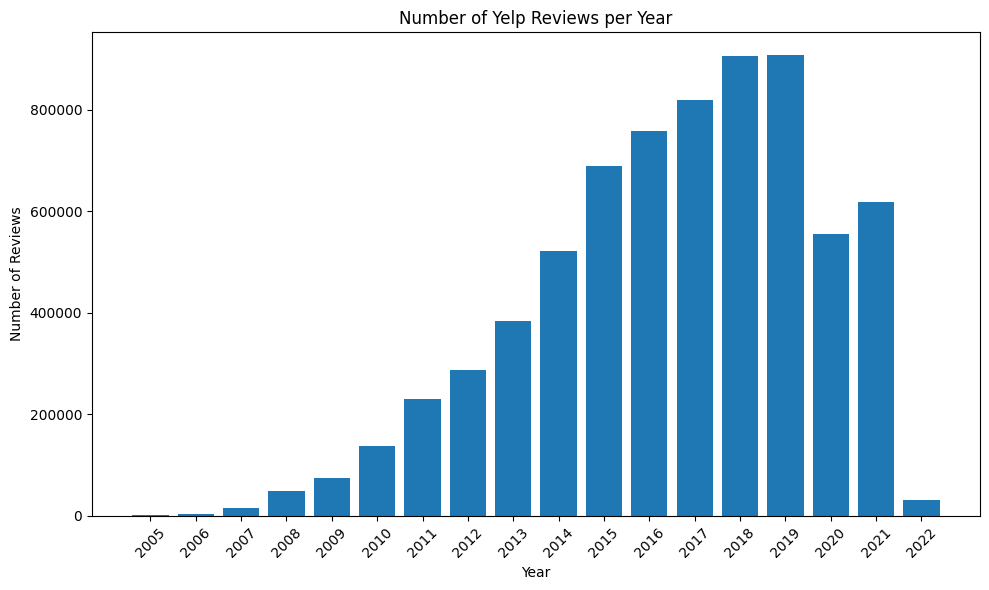

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(reviews_per_year['year'], reviews_per_year['count'])
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.title("Number of Yelp Reviews per Year")
plt.xticks(reviews_per_year['year'], rotation=45)
plt.tight_layout()
plt.show()

In [47]:
tips_per_year = (tip
                 .withColumn("parsed_date", unix_timestamp("date", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
                 .groupBy(year("parsed_date").alias("year"))
                 .count()
                 .orderBy("year")
                 .toPandas())

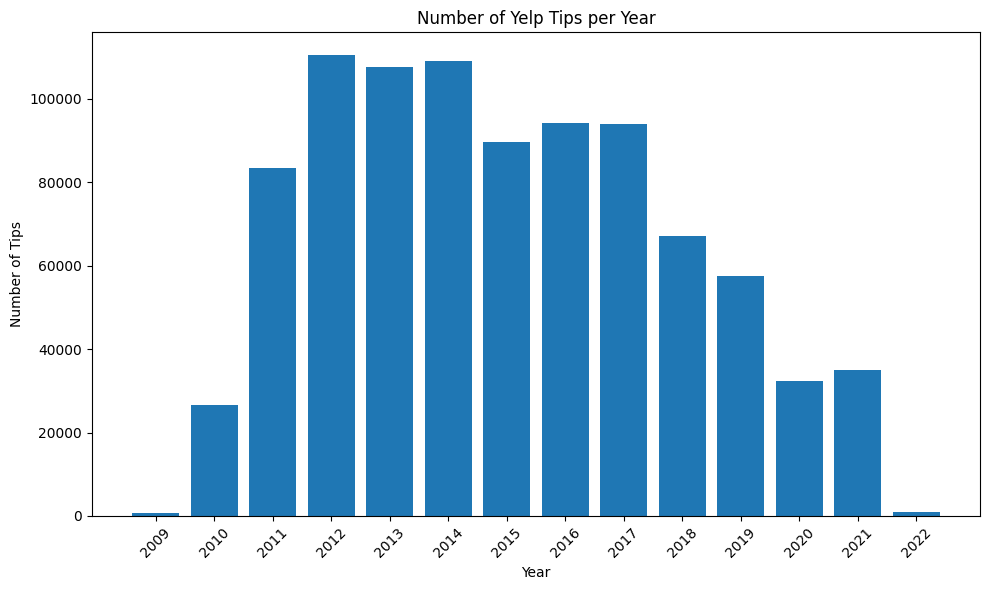

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(tips_per_year['year'], tips_per_year['count'])
plt.xlabel("Year")
plt.ylabel("Number of Tips")
plt.title("Number of Yelp Tips per Year")
plt.xticks(tips_per_year['year'], rotation=45)
plt.tight_layout()
plt.show()

In [56]:
reviews_per_business_per_year = (review
                                 .withColumn("parsed_date", unix_timestamp("date", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
                                 .groupBy(year("parsed_date").alias("year"), "business_id")
                                 .count()
                                 .orderBy("year", "business_id")
                                 .toPandas())

In [103]:
#aggregate reviews by business, get top 5 businesses based on the review count and filter data for those 5 businesses
top_businesses = reviews_per_business_per_year.groupby("business_id").sum()["count"].reset_index()
top_businesses = top_businesses.sort_values(by="count", ascending=False).head(5)
top_business_reviews = reviews_per_business_per_year[reviews_per_business_per_year["business_id"].isin(top_businesses["business_id"])]

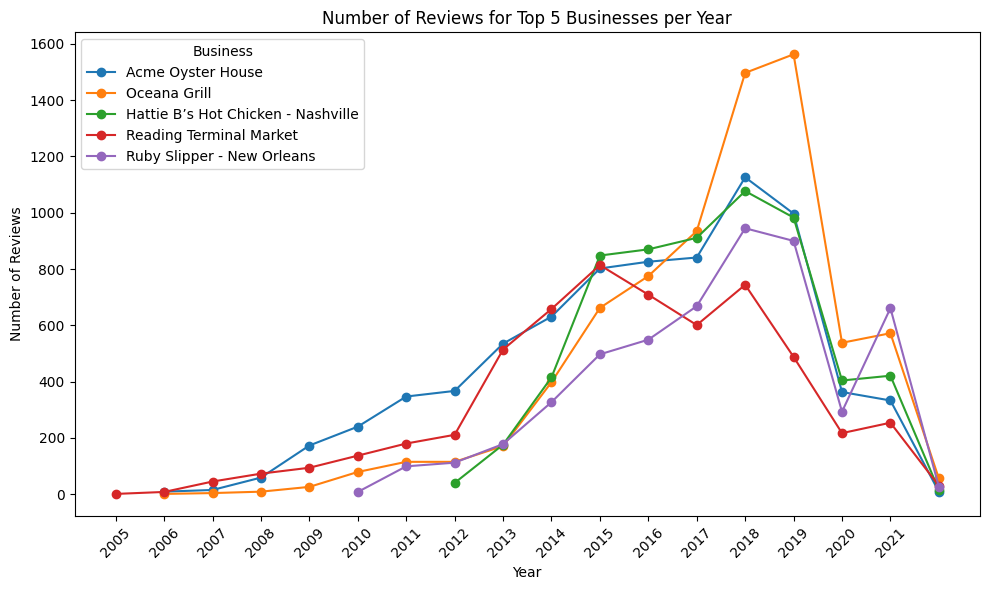

In [107]:
plt.figure(figsize=(10, 6))
for business_id in top_businesses["business_id"]:
    business_data = top_business_reviews[top_business_reviews["business_id"] == business_id]
    business_name = id_to_name.get(business_id, business_id)
    plt.plot(business_data["year"], business_data["count"], marker="o", label=business_name)

plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews for Top 5 Businesses per Year")
plt.legend(title="Business")

plt.xticks(range(2005, 2022), rotation=45)

plt.tight_layout()
plt.show()

In [61]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [62]:
sentiment_udf = udf(get_sentiment, FloatType())
review = review.withColumn("sentiment", sentiment_udf("text"))

In [64]:
tip = tip.withColumn("sentiment", sentiment_udf("text"))

In [66]:
tip.select("user_id", "business_id", "text", "sentiment").show(5)

+--------------------+--------------------+--------------------+-----------+
|             user_id|         business_id|                text|  sentiment|
+--------------------+--------------------+--------------------+-----------+
|AGNUgVwnZUey3gcPC...|3uLgwr0qeCNMjKenH...|Avengers time wit...|        0.0|
|NBN4MgHP9D3cw--Sn...|QoezRbYQncpRqyrLH...|They have lots of...|        0.7|
|-copOvldyKh1qr-vz...|MYoRNLb5chwjQe3c_...|It's open even wh...|        0.0|
|FjMQVZjSqY8syIO-5...|hV-bABTK-glh5wj31...|Very decent fried...|-0.19166666|
|ld0AperBXk1h6Ubqm...|_uN0OudeJ3Zl_tf6n...|Appetizers.. plat...| 0.35714287|
+--------------------+--------------------+--------------------+-----------+
only showing top 5 rows



In [67]:
avg_sentiment_per_year_tip = (tip
                              .withColumn("parsed_date", unix_timestamp("date", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
                              .groupBy(year("parsed_date").alias("year"))
                              .agg(avg("sentiment").alias("avg_sentiment"))
                              .orderBy("year")
                              .toPandas())

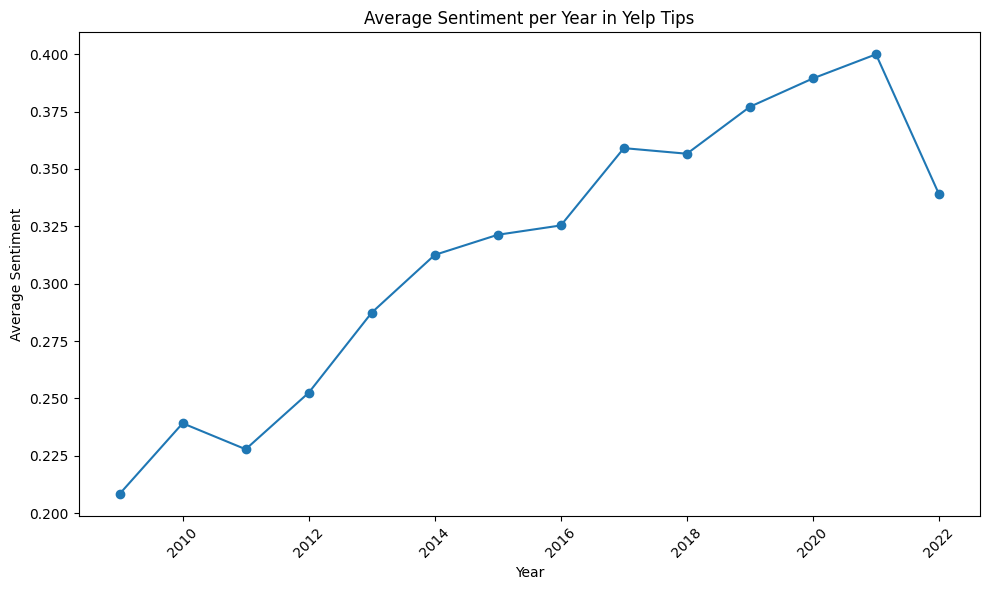

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(avg_sentiment_per_year_tip['year'], avg_sentiment_per_year_tip['avg_sentiment'], marker='o')
plt.xlabel("Year")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment per Year in Yelp Tips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
avg_sentiment_per_business_per_year = (tip
                                       .withColumn("parsed_date", unix_timestamp("date", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))
                                       .groupBy(year("parsed_date").alias("year"), "business_id")
                                       .agg(avg("sentiment").alias("avg_sentiment"))
                                       .orderBy("year", "business_id")
                                       .toPandas())

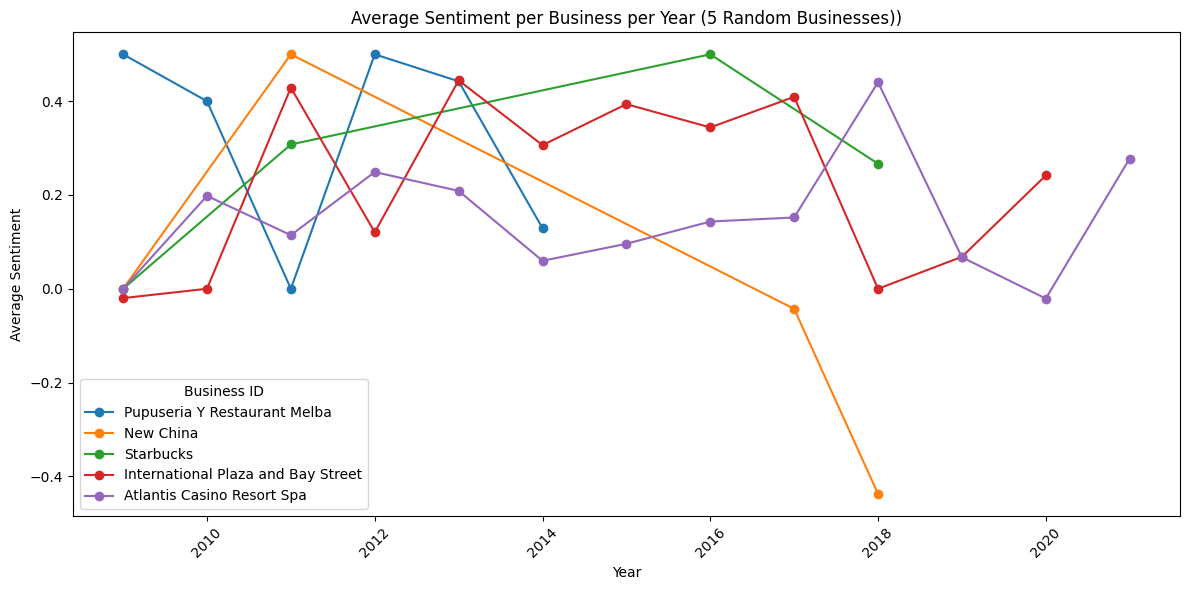

In [95]:
plt.figure(figsize=(12, 6))
for business_id in avg_sentiment_per_business_per_year["business_id"].unique()[:5]:
    business_data = avg_sentiment_per_business_per_year[
        avg_sentiment_per_business_per_year["business_id"] == business_id
    ]
    business_name = id_to_name.get(business_id, business_id)
    plt.plot(business_data["year"], business_data["avg_sentiment"], marker="o", label=business_name)


plt.xlabel("Year")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment per Business per Year (5 Random Businesses))")
plt.legend(title="Business ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()